# Audio Transcription

In this notebook we present a method for creating a harmonic trajectory from an Audio file. Given an Audio and a Midi file for the same piece of music we create the trajectory graph from the Audio using chroma features and from the Midi in the usual way.
We then check the adequacy of the Audio translation by comparing the graphs. We will use an evolutionary type algorithm to find the right threshold function that regognises which midi notes exist by frame of the chroma feature.

In [1]:
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display, sklearn, music21, ast, random, copy
import networkx as nx
import numpy as np
from tqdm import tqdm

from TrajectoryCalculationsWithClass import NewTrajectory
from graph_creation import createGrakel, createNX
from FirstNotePosition import PlaceFirstNote

C:\Users\melki\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\melki\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


#### Import Audio and apply high-pass and low-pass filters

In [2]:
x, sr = librosa.load('audio/midi_export.wav')
ipd.Audio(x, rate=sr)

Extract percussive elements

In [3]:
X = librosa.stft(x)
H, P = librosa.decompose.hpss(X)
h = librosa.istft(H)
ipd.Audio(h, rate=sr)

Apply high-pass filters on audio

In [4]:
from scipy.io import wavfile
from scipy import signal
# high-pass filter 
b = signal.firwin(31, cutoff=200, fs=sr, pass_zero=False)
h = signal.lfilter(b, [1.0], h)
ipd.Audio(h, rate=sr)

Apply low-pass filters on audio

In [5]:
def butter_lowpass_filter(audio, cutoff, sr):
    normal_cutoff = cutoff / (sr*0.5)
    # Get the filter coefficients 
    b, a = signal.butter(10, normal_cutoff, btype='low', analog=True)
    y = signal.filtfilt(b, a, audio)
    return y

h = butter_lowpass_filter(h, 3000, sr)
ipd.Audio(h, rate=sr)

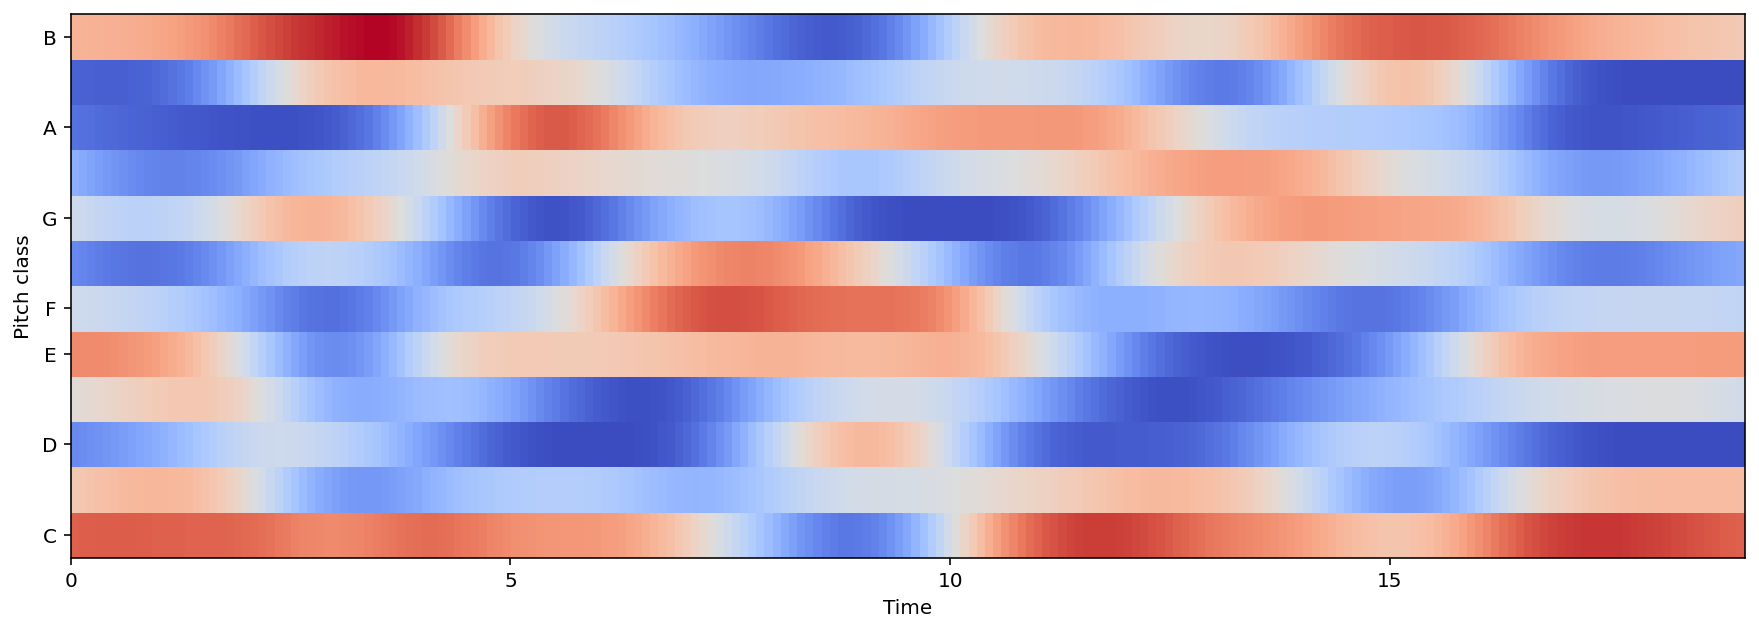

In [6]:
# correct format for librosa
h = np.asfortranarray(h)

# We take the chromagram which is a table of 12xN and N is the number of frames.
chromagram = librosa.feature.chroma_cens(h, sr=sr, hop_length=2048)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=2048, cmap='coolwarm')

In [7]:
# the threshold function
threshold = np.amax(0.35)

In [8]:
def get_chords(parsed_midi):
    mChords = parsed_midi.chordify()
    chordList = []
    for c in mChords.recurse().getElementsByClass('Chord'):
        chordList.append(c.orderedPitchClasses)    
    N = len(chordList)
    chordListNoDoubles = []
    sl = [str(i) for i in chordList]
    chordListNoDoubles.append(chordList[0])
    for i in range(1, N):
        if sl[i] != sl[i - 1]:
            chordListNoDoubles.append(ast.literal_eval(sl[i]))
    return chordListNoDoubles

def get_chords_audio(chromagram, threshold):
    N = len(chromagram[0])
    chordList = [list()]*N
    for pitch in range(12):
        for frame in range(N):
            if chromagram[pitch][frame] > threshold:
                chordList[frame] = chordList[frame] + [pitch]
    while [] in chordList:
        chordList.remove([])
    chordListNoDoubles = []
    sl = [str(i) for i in chordList]
    chordListNoDoubles.append(chordList[0])
    for i in range(1, len(chordList)):
        if sl[i] != sl[i - 1]:
            chordListNoDoubles.append(ast.literal_eval(sl[i]))
    return chordListNoDoubles

In [9]:
tonnetz = [3, 4, 5]

m = music21.converter.parse("Midi_files/midi_export.mid")
chordlist_midi = get_chords(m)
trajectory_midi = NewTrajectory(chordlist_midi, tonnetz, PlaceFirstNote(chordlist_midi, tonnetz))
graph_midi = createNX(trajectory_midi)

In [10]:
chordlist_audio = get_chords_audio(chromagram, threshold)
trajectory_audio = NewTrajectory(chordlist_audio, tonnetz, PlaceFirstNote(chordlist_audio, tonnetz))
graph_audio = createNX(trajectory_audio)

Graph Similarity algorithm

In [11]:
def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

laplacian1 = nx.spectrum.laplacian_spectrum(graph_midi)
laplacian2 = nx.spectrum.laplacian_spectrum(graph_audio)

k1 = select_k(laplacian1)
k2 = select_k(laplacian2)
k = min(k1, k2)

similarity = sum((laplacian1[:k] - laplacian2[:k])**2)

In [12]:
similarity

1426.7229875722996

In [13]:
nx.fast_could_be_isomorphic(graph_midi, graph_audio)

False

# Evolutionary Algorithm

In [14]:
def initialize_features():
    features = dict()
    features["cutoff_low"] = random.randrange(20, 200, 10)
    features["cutoff_high"] = random.randrange(2000, 20000, 200)
    features["chroma_type"] = random.choice(["chroma_cens", "chroma_stft", "chroma_cqt"])
    features["note_threshold"] = random.random()
    return features

def create_new_member(x, sr, f, tonnetz):  
    b = signal.firwin(31, cutoff=f["cutoff_low"], fs=sr, pass_zero=False)
    x = signal.lfilter(b, [1.0], x)
    x = butter_lowpass_filter(x, f["cutoff_high"], sr)
    # correct format for chromagram librosa
    x = np.asfortranarray(x)
    try:
        chromagram = librosa.feature.chroma_cens(x, sr=sr, hop_length=2048)
        chordlist_audio = get_chords_audio(chromagram, f["note_threshold"])
        trajectory_audio = NewTrajectory(chordlist_audio, tonnetz, PlaceFirstNote(chordlist_audio, tonnetz))
        graph_audio = createNX(trajectory_audio)
    except:
        graph_audio = nx.empty_graph()
    return graph_audio, f

def create_starting_population(size, x, sr, tonnetz):
    
    #this just creates a population of different routes of a fixed size.  Pretty straightforward.
    
    population = []
    
    for i in range(0,size):
        f = initialize_features()
        population.append(create_new_member(x, sr, f, tonnetz))
        
    return population

def fitness(graph_audio, graph_midi):
    try:
        laplacian1 = nx.spectrum.laplacian_spectrum(graph_midi)
        laplacian2 = nx.spectrum.laplacian_spectrum(graph_audio)

        k1 = select_k(laplacian1)
        k2 = select_k(laplacian2)
        k = min(k1, k2)

        similarity = sum((laplacian1[:k] - laplacian2[:k])**2)
    except:
        similarity = 10000
    return similarity

def crossover(member1, member2, tonnetz):
    
    # the second projection are the features
    f1 = member1[1]
    f2 = member2[1]
    
    f_temp = [f1["cutoff_low"], f1["cutoff_low"]]
    if f_temp[0] != f_temp[1]:
        f1["cutoff_low"] = random.randrange(min(f_temp), max(f_temp), 10)
        f2["cutoff_low"] = random.randrange(f1["cutoff_low"], f2["cutoff_low"], 10)
        
    f_temp = [f1["cutoff_high"], f1["cutoff_high"]]
    if f_temp[0] != f_temp[1]:
        f1["cutoff_high"] = random.randrange(min(f_temp), max(f_temp), 200)
        f2["cutoff_high"] = random.randrange(min(f_temp), max(f_temp), 200)
    
    f_temp = [f1["note_threshold"], f1["note_threshold"]]
    if f_temp[0] != f_temp[1]:
        f1["note_threshold"] = random.uniform(min(f_temp), max(f_temp))
        f2["note_threshold"] = random.uniform(min(f_temp), max(f_temp))
    
    return (create_new_member(x, sr, f1, tonnetz), create_new_member(x, sr, f2, tonnetz))

def score_population(population, graph_midi):

    scores = []
    
    for i in range(0, len(population)):
        scores += [fitness(population[i][0], graph_midi)]
        
    return scores

def pick_mate(scores):

    array = np.array(scores)
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))

    fitness = [len(ranks) - x for x in ranks]
    
    cum_scores = copy.deepcopy(fitness)
    
    for i in range(1,len(cum_scores)):
        cum_scores[i] = fitness[i] + cum_scores[i-1]
        
    probs = [x / cum_scores[-1] for x in cum_scores]
    
    rand = random.random()
    
    for i in range(0, len(probs)):
        if rand < probs[i]:
            
            return i
        
def main(graph_midi, x, sr, tonnetz):
    
    # parameters
    population_size = 20
    number_of_iterations = 60
    number_of_couples = 10
    number_of_winners_to_keep = 1

    # create the starting population
    population = create_starting_population(population_size, x, sr, tonnetz)

    last_similarity = 100000000
    # for a large number of iterations do:
        
    for i in tqdm(range(0,number_of_iterations)):
        new_population = []
        
        # evaluate the fitness of the current population
        scores = score_population(population, graph_midi)

        best = population[np.argmin(scores)]
#         number_of_moves = len(best)
        similarity = fitness(best[0], graph_midi)
        
        if similarity != last_similarity:
            print('Iteration %i: Best so far is steps for a similarity of %f' % (i, similarity))
        
        # allow members of the population to breed based on their relative score; 
            # i.e., if their score is higher they're more likely to breed
        for j in range(0, number_of_couples):  
            new_1, new_2 = crossover(population[pick_mate(scores)], population[pick_mate(scores)], tonnetz)
            new_population = new_population + [new_1, new_2]
  
        # mutate
#         for j in range(0, len(new_population)):
#             new_population[j] = np.copy(mutate(new_population[j], 0.05, the_map))
            
        # keep members of previous generation
        new_population += [population[np.argmin(scores)]]
        for j in range(1, number_of_winners_to_keep):
            keeper = pick_mate(scores)            
            new_population += [population[keeper]]
            
        # add new random members
        while len(new_population) < population_size:
            f = initialize_features()
            new_population += [create_new_member(x, sr, f, tonnetz)]
            
        #replace the old population with a real copy
        population = copy.deepcopy(new_population)
                
        last_similarity = similarity
    return(best)
        

In [15]:
x, sr = librosa.load('audio/midi_export.wav')

tonnetz = [3, 4, 5]

m = music21.converter.parse("Midi_files/midi_export.mid")
chordlist_midi = get_chords(m)
trajectory_midi = NewTrajectory(chordlist_midi, tonnetz, PlaceFirstNote(chordlist_midi, tonnetz))
graph_midi = createNX(trajectory_midi)

In [29]:
f = initialize_features()
f["cutoff_low"] = 200
f["cutoff_high"] = 5000
f["note_threshold"] = 0.3
g, f = create_new_member(x, sr, f, tonnetz)

In [23]:
nx.graph_edit_distance(graph_midi, g)

15.0

In [47]:
from func_timeout import func_timeout

def graph_similarity(G1, G2):
    for v in nx.optimize_graph_edit_distance(G1, G2):
        minv = v
    return minv
    
try:
    func_timeout(5, graph_similarity, args=(graph_midi, g))
except:
    print("Timed Out")

Timed Out
